<a href="https://colab.research.google.com/github/kireeti-kunam/severstal-steel-defect-detection/blob/main/segmentation_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Loading Libraries:

In [ ]:
#scikit-learn/python libraries:
#------------------------
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt
import math
import os
from datetime import datetime
import pickle


#tensor-flow and keras libraries:
#------------------------

import tensorflow as tf
import keras
from keras import backend as K
#from tensorflow.keras.utils.generic_utils import get_custom_objects
from tensorflow.keras import initializers, constraints, regularizers, layers
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dropout, Conv2D, BatchNormalization,Conv2DTranspose,MaxPooling2D,Add,LeakyReLU
from tensorflow.keras.layers import concatenate
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.optimizers import Adam
from glob import glob
from tensorflow.keras.callbacks import Callback, ModelCheckpoint


Using TensorFlow backend.


## 2.Downloading and Loading Data:

#### Kaggle data files:

In [ ]:
!wget --header="Host: storage.googleapis.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/84.0.4147.89 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9,zh-CN;q=0.8,zh;q=0.7" --header="Referer: https://www.kaggle.com/" "https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/14241/862020/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1595305372&Signature=pQoVIE6Dc0RcZa7A5juIqmcpDGdJUit9g96JW6op0eCJzYogFcuwze%2B8%2BUkMuXx9kWO9CzfyixRhQGFCIgxLCZpyHqf3bFjQIrQ2CZVQ9TYUsTfhuU8baOCE%2FzZxsJkMhTGWafR%2BDQsuRkA6PtbwBsgniK7JNfIzKpYymAFox19WFIDO6UISONL5kumc%2BOCmbXDkHcNMYzNLumnkFTy%2BiqTh0raBaCf5WcnsS2exFqTQez6hTILzf2elTFhmOvdvljp4bTgpD%2F39kqDDdhNfhDcUBQuUMlu4Ha6vUuVZXUlUjR2OBNel5O8k7fdQb69%2BNsOzFRlYNU8kSc5A3w8svQ%3D%3D&response-content-disposition=attachment%3B+filename%3Dseverstal-steel-defect-detection.zip" -c -O 'severstal-steel-defect-detection.zip'

--2020-07-18 04:23:10--  https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/14241/862020/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1595305372&Signature=pQoVIE6Dc0RcZa7A5juIqmcpDGdJUit9g96JW6op0eCJzYogFcuwze%2B8%2BUkMuXx9kWO9CzfyixRhQGFCIgxLCZpyHqf3bFjQIrQ2CZVQ9TYUsTfhuU8baOCE%2FzZxsJkMhTGWafR%2BDQsuRkA6PtbwBsgniK7JNfIzKpYymAFox19WFIDO6UISONL5kumc%2BOCmbXDkHcNMYzNLumnkFTy%2BiqTh0raBaCf5WcnsS2exFqTQez6hTILzf2elTFhmOvdvljp4bTgpD%2F39kqDDdhNfhDcUBQuUMlu4Ha6vUuVZXUlUjR2OBNel5O8k7fdQb69%2BNsOzFRlYNU8kSc5A3w8svQ%3D%3D&response-content-disposition=attachment%3B+filename%3Dseverstal-steel-defect-detection.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.69.128, 173.194.79.128, 108.177.119.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.69.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1684204253 (1.6G) [application/zip]
Saving to: ‘severstal-steel-d

In [ ]:
## unzipping the data files:

from zipfile import ZipFile
with ZipFile('severstal-steel-defect-detection.zip', 'r') as zf:
    zf.extractall('case_study_2_data/')

#### Google drive data files:

In [ ]:
## Mounting google drive:

from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# loading nessasary drive files(already created) :
# reading from csv files

train_data = pd.read_csv("/content/drive/My Drive/case_study_2_data/train_data.csv")
train_data = train_data.replace(np.nan, '', regex=True)

cv_data = pd.read_csv("/content/drive/My Drive/case_study_2_data/cv_data.csv")
cv_data = cv_data.replace(np.nan, '', regex=True)

<br>

In [ ]:
train_data.head(2)

,image_id,defect_1,defect_2,defect_3,defect_4,has_defect,has_defect_1,has_defect_2,has_defect_3,has_defect_4
0,c70702ea2.jpg,,,,34545 4 34798 12 35050 20 35287 4 35303 26 355...,1,0,0,0,1
1,7e79e75ca.jpg,,,,,0,0,0,0,0


In [ ]:
cv_data.head(2)

,image_id,defect_1,defect_2,defect_3,defect_4,has_defect,has_defect_1,has_defect_2,has_defect_3,has_defect_4
0,bdc800e05.jpg,,,,,0,0,0,0,0
1,d9285f64c.jpg,,,,,0,0,0,0,0


## 2.Image operations:

 - Def body: run length encoding to mask and augmentation on mask

 - Def rle_decode_tf_train: Load train image and performing augmentation and it will return Image and Mask.

 - Def rle_decode_tf_test: Load test image and return test image and mask without any augmentation.

In [ ]:
@tf.function
def body(mask_rle,random_number,training):
  shape = tf.convert_to_tensor((1600,256), tf.int64)
  size = tf.math.reduce_prod(shape)
  # Split string
  s = tf.strings.split(mask_rle)
  s = tf.strings.to_number(s, tf.int64)
  # Get starts and lengths
  starts = s[::2] - 1
  lens = s[1::2]
  # Make ones to be scattered
  total_ones = tf.reduce_sum(lens)
  ones = tf.ones([total_ones], tf.uint8)
  # Make scattering indices
  r = tf.range(total_ones)
  lens_cum = tf.math.cumsum(lens)
  s = tf.searchsorted(lens_cum, r, 'right')
  idx = r + tf.gather(starts - tf.pad(lens_cum[:-1], [(1, 0)]), s)
  # Scatter ones into flattened mask
  mask_flat = tf.scatter_nd(tf.expand_dims(idx, 1), ones, [size])
  # Reshape into mask
  mask  = tf.transpose(tf.reshape(mask_flat, shape)[::2,::])
  if training == True:
    mask = tf.expand_dims(mask,2)
    # Data augmentation based on randomness
    """ Mask Flipping Please check"""
    if random_number > 0.5:
      mask = tf.image.flip_left_right(mask)
    # Data augmentation based on randomness
    """ Mask Flipping Please check"""
    if random_number > 0.8:
      mask = tf.image.flip_up_down(mask)
    mask =  mask[:,:,0] 
  return mask

In [ ]:
@tf.function
def rle_decode_tf_train(image_id, defect_1_rle):
   
    filename = "/content/case_study_2_data/train_images/"+ image_id  # full path

    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image)

    random_number = tf.random.uniform(())
    if random_number > 0.5:
      image  = tf.image.adjust_brightness(image,delta=0.2)
      image = tf.image.flip_left_right(image)
    if random_number > 0.8:
      image  = tf.image.adjust_brightness(image,delta=0.2)
      image = tf.image.flip_up_down(image) 

    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [256, 800])

    # Decoding of the encdoed RLE

    zeroes = tf.zeros((256,800), dtype=tf.dtypes.uint8)
    """ Mask Flipping Please check see in body function"""

    mask = tf.cond(defect_1_rle == '0',lambda:zeroes ,lambda: body(defect_1_rle,random_number,True))

      
    return image,mask

In [ ]:
#@tf.function
def rle_decode_tf_test(image_id, defect_1_rle):
    
    filename = "/content/case_study_2_data/train_images/"+ image_id  # full path

    image = tf.io.read_file(filename) 
    image = tf.image.decode_jpeg(image)

    random_number = tf.random.uniform(())

    # Use `convert_image_dtype` to convert to floats in the [0,1] range.

    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [256, 800])

    # Decoding of the encdoed RLE

    zeroes = tf.zeros((256,800), dtype=tf.dtypes.uint8)
    mask = tf.cond(defect_1_rle == '0',lambda:zeroes ,lambda: body(defect_1_rle,.2,False)) # "False" for witout masking

    return image,mask

<br>

## 3.Building Models:

In [ ]:
def convolution_block(x, filters, size, strides=(1,1), padding='same', activation=True):
    x = Conv2D(filters, size, strides=strides, padding=padding)(x)
    x = BatchNormalization()(x)
    if activation == True:
        x = LeakyReLU(alpha=0.1)(x)
    return x

def residual_block(blockInput, num_filters=16):
    x = LeakyReLU(alpha=0.1)(blockInput)
    x = BatchNormalization()(x)
    blockInput = BatchNormalization()(blockInput)
    x = convolution_block(x, num_filters, (3,3) )
    x = convolution_block(x, num_filters, (3,3), activation=False)
    x = Add()([x, blockInput])
    return x

In [ ]:
def UDense(input_shape=(None, None, 3),dropout_rate=0.5):

    backbone = tf.keras.applications.DenseNet121(weights='imagenet',
                            include_top=False,
                            input_shape=(256,800,3))

    input = backbone.input
    start_neurons = 8
    
    conv4 = backbone.layers[311].output
    conv4 = LeakyReLU(alpha=0.1)(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(dropout_rate)(pool4)
    
     # Middle
    convm = Conv2D(start_neurons * 32, (3, 3), activation=None, padding="same")(pool4)
    convm = residual_block(convm,start_neurons * 32)
    convm = residual_block(convm,start_neurons * 32)
    convm = LeakyReLU(alpha=0.1)(convm)
    
    deconv4 = Conv2DTranspose(start_neurons * 16, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(dropout_rate)(uconv4)
    
    uconv4 = Conv2D(start_neurons * 16, (3, 3), activation=None, padding="same")(uconv4)
    uconv4 = residual_block(uconv4,start_neurons * 16)
    uconv4 = residual_block(uconv4,start_neurons * 16)
    uconv4 = LeakyReLU(alpha=0.1)(uconv4)
    
    deconv3 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(uconv4)
    conv3 = backbone.layers[139].output
    uconv3 = concatenate([deconv3, conv3])    
    uconv3 = Dropout(dropout_rate)(uconv3)
    
    uconv3 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(uconv3)
    uconv3 = residual_block(uconv3,start_neurons * 8)
    uconv3 = residual_block(uconv3,start_neurons * 8)
    uconv3 = LeakyReLU(alpha=0.1)(uconv3)

    deconv2 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv3)
    conv2 = backbone.layers[51].output
    uconv2 = concatenate([deconv2, conv2])
        
    uconv2 = Dropout(0.1)(uconv2)
    uconv2 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(uconv2)
    uconv2 = residual_block(uconv2,start_neurons * 4)
    uconv2 = residual_block(uconv2,start_neurons * 4)
    uconv2 = LeakyReLU(alpha=0.1)(uconv2)
    
    deconv1 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv2)
    conv1 = backbone.layers[4].output
    uconv1 = concatenate([deconv1, conv1])
    
    uconv1 = Dropout(0.1)(uconv1)
    uconv1 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(uconv1)
    uconv1 = residual_block(uconv1,start_neurons * 2)
    uconv1 = residual_block(uconv1,start_neurons * 2)
    uconv1 = LeakyReLU(alpha=0.1)(uconv1)
    
    uconv0 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv1)   
    uconv0 = Dropout(0.1)(uconv0)
    uconv0 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(uconv0)
    uconv0 = residual_block(uconv0,start_neurons * 1)
    uconv0 = residual_block(uconv0,start_neurons * 1)
    uconv0 = LeakyReLU(alpha=0.1)(uconv0)
    
    uconv0 = Dropout(dropout_rate/2)(uconv0)
    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv0)    
    
    model = Model(input, output_layer)
   # model.name = 'u-xception'

    return model

In [ ]:
seg_model = UDense((256,800,3),dropout_rate=0.5)
seg_model.summary()

29089792/29084464 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 800, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 262, 806, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 128, 400, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 128, 400, 64) 256         conv1/conv[0][0]                 
_____________________________

##### Defining loss functions:

In [ ]:
@tf.function
def DiceLoss(y_true,y_pred):

  smooth = 1e-6
  intersection = tf.reduce_sum(y_true * y_pred)
  dice_score = (2 * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)
  dice_score = tf.cast(dice_score,'float32')
  
  return 1.0 - dice_score

@tf.function
def Dicecoef(y_true,y_pred):
  
  smooth = 1
  intersection = tf.reduce_sum(y_true * y_pred)
  dice_score = (2 * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)
  dice_score = tf.cast(dice_score,'float32')
  
  return dice_score

@tf.function
def Bce_dice_loss(y_true, y_predict): #combination of dice loss and binary cross entropy for all pixels
    return binary_crossentropy(y_true, y_predict) + (1-Dicecoef(y_true, y_predict))

##### Defining functions for plotting :

In [ ]:
def plot_model_history(history):
    '''function to plot epoch vs bce_dice_loss & epoch vs dice_coeff '''
    # plot bce_dice_loss
    plt.subplot(121)
    plt.title('bce_dice_loss')
    plt.xlabel('Epoch')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='CV')
    plt.legend(['train', 'cv'], loc='upper right')

    # plot dice_coeff
    plt.subplot(122)
    plt.title('Dice_coef')
    plt.xlabel('Epoch')
    plt.plot(history.history['Dicecoef'], color='blue', label='train')
    plt.plot(history.history['val_Dicecoef'], color='orange', label='CV')
    plt.legend(['train', 'cv'], loc='upper left')

## 4.Building segmentation models:

### 4.1 Building segmentation model for Defect-1:

### DataFrame Operations:

In [ ]:
# Filtering only Defect_1 ImageID's and Rle's:
#-----------------------------------------------

defect_1_train_data  = train_data[train_data['has_defect_1']==1][['image_id','defect_1']].reset_index(drop=True)
defect_1_val_data    = cv_data[cv_data['has_defect_1']==1][['image_id','defect_1']].reset_index(drop=True)


<br>

Image and mask shapes are: (256, 800, 3) (256, 800)


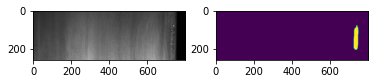

In [ ]:
#sanity checking for image and mask

image_sample,mask_sample = rle_decode_tf_train(defect_1_train_data['image_id'].iloc[0],defect_1_train_data['defect_1'].iloc[0])
plt.subplot(1,2,1)
plt.imshow(image_sample)
plt.subplot(1,2,2)
plt.imshow(mask_sample)

print("Image and mask shapes are:",image_sample.shape,mask_sample.shape)

### Building pipelines:

In [ ]:
batch= 8
batch_val = 8
global iters_train

iters_train  =  defect_1_train_data.shape[0]//batch
iters_test   =  defect_1_val_data.shape[0]//batch

# creating the data pipeline
train_dataset  = tf.data.Dataset.from_tensor_slices((defect_1_train_data['image_id'], defect_1_train_data['defect_1']))
val_dataset     = tf.data.Dataset.from_tensor_slices((defect_1_val_data['image_id'] , defect_1_val_data['defect_1']))


train_dataset  = train_dataset.cache().shuffle(defect_1_train_data.shape[0],seed=batch,reshuffle_each_iteration=False)\
                .map(rle_decode_tf_train,num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(batch).prefetch(tf.data.experimental.AUTOTUNE)

# # We are creating 16 batch as we have 256,800 pixels i want to train which need more computation Power

val_dataset     = val_dataset.cache().map(rle_decode_tf_test,num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(batch_val).prefetch(tf.data.experimental.AUTOTUNE)


<br>

In [ ]:
seg_model.compile(optimizer=tf.keras.optimizers.Adam(),loss=Bce_dice_loss,metrics=[Dicecoef])

In [ ]:
# checkpoints for model saving:

checkpoint_path = "/content/drive/My Drive/seg_models/defect_1/cp.ckpt"
checkpoint_dir  = os.path.dirname(checkpoint_path)

cp_callback     = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                    save_weights_only=False,
                                                    save_best_only = False,
                                                    verbose=1)
#so that we can reload it whenever we want along with model architecture,weights and states

 


In [ ]:
defect_1_history = seg_model.fit(train_dataset,epochs=40,validation_data=val_dataset,callbacks=[cp_callback])

Epoch 1/40
83/83 [==============================] - ETA: 0s - loss: 1.5240 - Dicecoef: 0.0244
Epoch 00001: saving model to /content/drive/My Drive/seg_models/defect_1/cp.ckpt
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /content/drive/My Drive/seg_models/defect_1/cp.ckpt/assets
83/83 [==============================] - 135s 2s/step - loss: 1.5240 - Dicecoef: 0.0244 - val_loss: 1.4262 - val_Dicecoef: 0.0219
Epoch 2/40
83/83 [==============================] - ETA: 0s - loss: 1.3152 - Dicecoef: 0.0290
Epoch 00002: saving model to /content/drive/My Drive/seg_models/defect_1/cp.ckpt
INFO:tensorflow:Assets written to: /content/drive/My Drive/seg_models/defect_1/cp.ckpt/assets
83/83 [==============================] - 128s 2s/step - loss: 1.3152 - Dicecoef: 0.0290 - val_loss: 1.2304 - val_Dicecoef: 0.0234
Epoch 3/40
83/83 [==============================] - ETA: 0s - loss: 1.2446 - Dicecoef: 0.0335
Epoch 00003: saving model t

In [ ]:
# dump history in file (for future reference):

with open('/content/drive/My Drive/seg_models/defect_1/history', 'wb') as file_pi:
        pickle.dump(defect_1_history.history, file_pi)

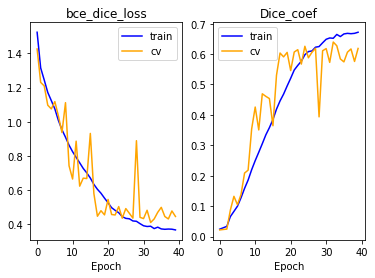

In [ ]:
plot_model_history(defect_1_history)

<br>

<br>

### Testting the segmentation model -1: (for defect-1)

In [ ]:
# To reload entire saved model (along with architecture,weights,object states)

import logging
logging.getLogger('tensorflow').disabled = True
tf.keras.backend.clear_session()


defect_1_model = tf.keras.models.load_model('/content/drive/My Drive/seg_models/defect_1/cp.ckpt/',
                                            custom_objects={'Bce_dice_loss':Bce_dice_loss,'Dicecoef':Dicecoef})


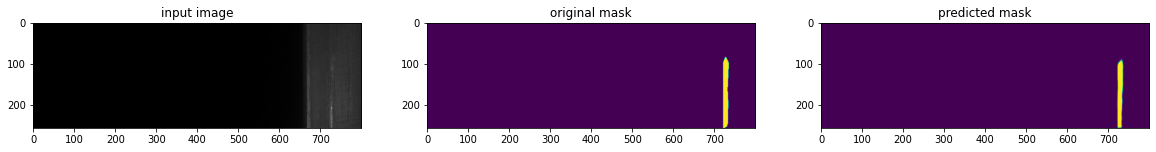

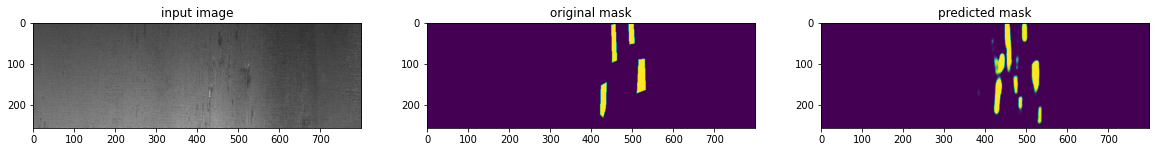

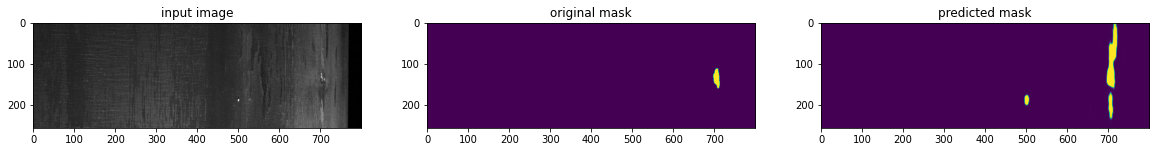

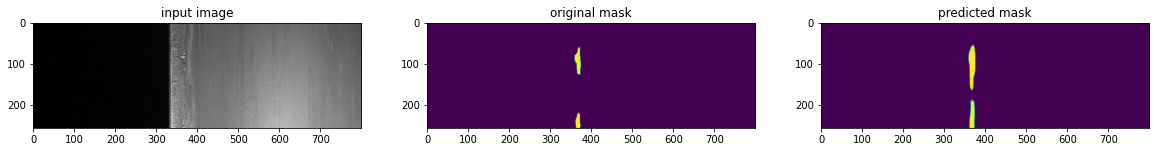

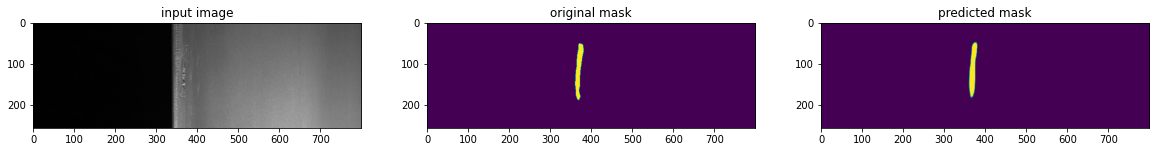

In [ ]:
for index,row in defect_1_val_data.loc[0:4].iterrows():
  image,mask = rle_decode_tf_test(row['image_id'],row['defect_1'])
  image_reshaped = np.expand_dims(image,axis=0)
  predicted_mask = defect_1_model.predict(image_reshaped)
  predicted_mask = np.squeeze(predicted_mask, axis=-1)
  predicted_mask = np.squeeze(predicted_mask, axis=0)

  fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20, 13))

  ax1.set_title('input image')
  ax1.imshow(image)

  ax2.set_title('original mask')
  ax2.imshow(mask)

  ax3.set_title('predicted mask')
  ax3.imshow(predicted_mask)




  


<br>

### 4.2 Building segmentation model for Defect-2:

### DataFrame Operations:

In [ ]:
# Filtering only Defect_1 ImageID's and Rle's:
#-----------------------------------------------

defect_2_train_data  = train_data[train_data['has_defect_2']==1][['image_id','defect_2']].reset_index(drop=True)
defect_2_val_data    = cv_data[cv_data['has_defect_2']==1][['image_id','defect_2']].reset_index(drop=True)


<br>

### Building pipelines:

In [ ]:
batch= 8
batch_val = 8
global iters_train

iters_train  =  defect_2_train_data.shape[0]//batch
iters_test   =  defect_2_val_data.shape[0]//batch

# creating the data pipeline
train_dataset  = tf.data.Dataset.from_tensor_slices((defect_2_train_data['image_id'], defect_2_train_data['defect_2']))
val_dataset     = tf.data.Dataset.from_tensor_slices((defect_2_val_data['image_id'] , defect_2_val_data['defect_2']))


train_dataset  = train_dataset.cache().shuffle(defect_2_train_data.shape[0],seed=batch,reshuffle_each_iteration=False)\
                .map(rle_decode_tf_train,num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(batch).prefetch(tf.data.experimental.AUTOTUNE)

# # We are creating 16 batch as we have 256,800 pixels i want to train which need more computation Power

val_dataset     = val_dataset.cache().map(rle_decode_tf_test,num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(batch_val).prefetch(tf.data.experimental.AUTOTUNE)


<br>

In [ ]:
# checkpoints for model saving:

checkpoint_path = "/content/drive/My Drive/seg_models/defect_2/cp.ckpt"
checkpoint_dir  = os.path.dirname(checkpoint_path)

cp_callback     = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                    save_weights_only=False,
                                                    save_best_only = False,
                                                    verbose=1)
#so that we can reload it whenever we want along with model architecture,weights and states 


In [ ]:
seg_model.compile(optimizer=tf.keras.optimizers.Adam(),loss=Bce_dice_loss,metrics=[Dicecoef])

In [ ]:
defect_2_history = seg_model.fit(train_dataset,epochs=35,validation_data=val_dataset,callbacks=[cp_callback])

Epoch 1/35
25/25 [==============================] - ETA: 0s - loss: 1.2770 - Dicecoef: 0.0191
Epoch 00001: saving model to /content/drive/My Drive/seg_models/defect_2/cp.ckpt
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /content/drive/My Drive/seg_models/defect_2/cp.ckpt/assets
25/25 [==============================] - 88s 4s/step - loss: 1.2770 - Dicecoef: 0.0191 - val_loss: 1.2870 - val_Dicecoef: 0.0176
Epoch 2/35
25/25 [==============================] - ETA: 0s - loss: 1.1506 - Dicecoef: 0.0299
Epoch 00002: saving model to /content/drive/My Drive/seg_models/defect_2/cp.ckpt
INFO:tensorflow:Assets written to: /content/drive/My Drive/seg_models/defect_2/cp.ckpt/assets
25/25 [==============================] - 75s 3s/step - loss: 1.1506 - Dicecoef: 0.0299 - val_loss: 1.0872 - val_Dicecoef: 0.0215
Epoch 3/35
25/25 [==============================] - ETA: 0s - loss: 1.0821 - Dicecoef: 0.0593
Epoch 00003: saving model to 

In [ ]:
# dump history in file (for future reference):

with open('/content/drive/My Drive/seg_models/defect_2/history', 'wb') as file_pi:
        pickle.dump(defect_2_history.history, file_pi)

In [ ]:
# To reload entire saved model (along with architecture,weights,object states)

defect_2_model = tf.keras.models.load_model('/content/drive/My Drive/seg_models/defect_2/cp.ckpt/',
                                            custom_objects={'Bce_dice_loss':Bce_dice_loss,'Dicecoef':Dicecoef})

loss, acc      = defect_2_model.evaluate(val_dataset, verbose=2)

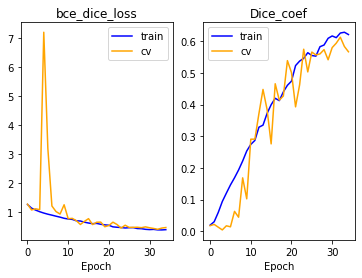

In [ ]:
plot_model_history(defect_2_history)

<br>

<br>

### Testting the segmentation model -2: (for defect-2)

In [ ]:
# To reload entire saved model (along with architecture,weights,object states)

import logging
logging.getLogger('tensorflow').disabled = True
tf.keras.backend.clear_session()


defect_2_model = tf.keras.models.load_model('/content/drive/My Drive/seg_models/defect_2/cp.ckpt/',
                                            custom_objects={'Bce_dice_loss':Bce_dice_loss,'Dicecoef':Dicecoef})


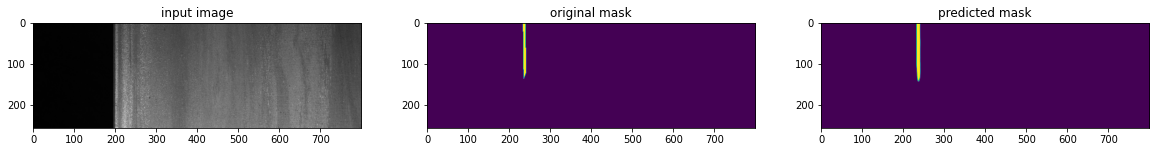

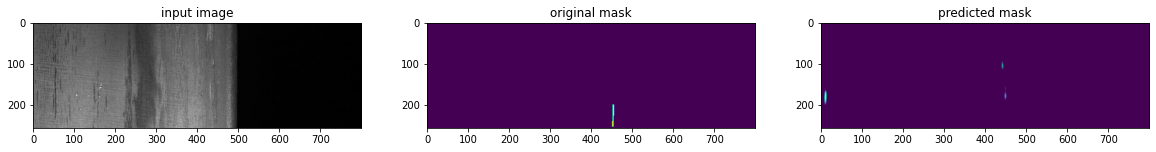

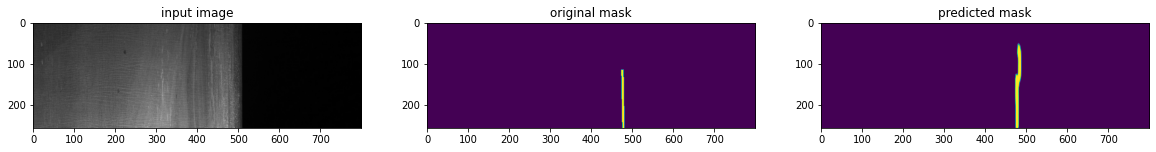

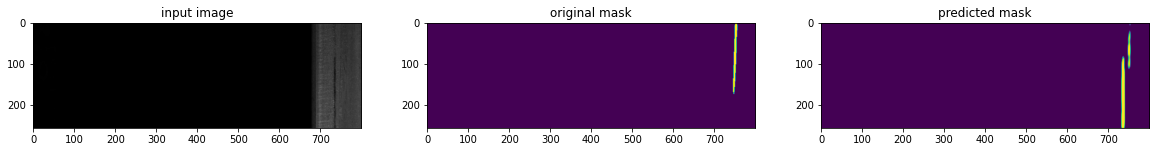

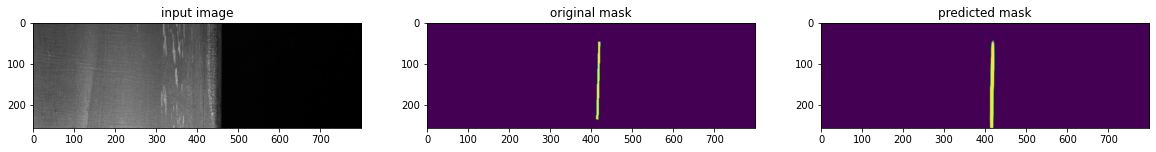

In [ ]:
for index,row in defect_2_val_data.loc[0:4].iterrows():
  image,mask = rle_decode_tf_test(row['image_id'],row['defect_2'])
  image_reshaped = np.expand_dims(image,axis=0)
  predicted_mask = defect_2_model.predict(image_reshaped)
  predicted_mask = np.squeeze(predicted_mask, axis=-1)
  predicted_mask = np.squeeze(predicted_mask, axis=0)

  fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20, 13))

  ax1.set_title('input image')
  ax1.imshow(image)

  ax2.set_title('original mask')
  ax2.imshow(mask)

  ax3.set_title('predicted mask')
  ax3.imshow(predicted_mask)
  

<br>
<br>

<br>

### 4.3 Building segmentation model for Defect-3:

### DataFrame Operations:

In [ ]:
# Filtering only Defect_1 ImageID's and Rle's:
#-----------------------------------------------

defect_3_train_data  = train_data[train_data['has_defect_3']==1][['image_id','defect_3']].reset_index(drop=True)
defect_3_val_data    = cv_data[cv_data['has_defect_3']==1][['image_id','defect_3']].reset_index(drop=True)


<br>

### Building pipelines:

In [ ]:
batch= 8
batch_val = 8
global iters_train

iters_train  =  defect_3_train_data.shape[0]//batch
iters_test   =  defect_3_val_data.shape[0]//batch

# creating the data pipeline
train_dataset   = tf.data.Dataset.from_tensor_slices((defect_3_train_data['image_id'], defect_3_train_data['defect_3']))
val_dataset     = tf.data.Dataset.from_tensor_slices((defect_3_val_data['image_id'] , defect_3_val_data['defect_3']))


train_dataset  = train_dataset.cache().shuffle(defect_3_train_data.shape[0],seed=batch,reshuffle_each_iteration=False)\
                .map(rle_decode_tf_train,num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(batch).prefetch(tf.data.experimental.AUTOTUNE)

# # We are creating 16 batch as we have 256,800 pixels i want to train which need more computation Power

val_dataset     = val_dataset.cache().map(rle_decode_tf_test,num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(batch_val).prefetch(tf.data.experimental.AUTOTUNE)


<br>

In [ ]:
seg_model.compile(optimizer=tf.keras.optimizers.Adam(),loss=Bce_dice_loss,metrics=[Dicecoef])

In [ ]:
# checkpoints for model saving:

checkpoint_path = "/content/drive/My Drive/seg_models/defect_3/cp.ckpt"
checkpoint_dir  = os.path.dirname(checkpoint_path)

cp_callback     = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                    save_weights_only=False,
                                                    save_best_only = False,
                                                    verbose=1)
#so that we can reload it whenever we want along with model architecture,weights and states
 


In [ ]:
defect_3_history = seg_model.fit(train_dataset, epochs=30, callbacks=[cp_callback], validation_data=val_dataset)

Epoch 1/30
518/518 [==============================] - ETA: 0s - loss: 0.5974 - Dicecoef: 0.5598
Epoch 00001: saving model to /content/drive/My Drive/seg_models/defect_3/cp.ckpt
INFO:tensorflow:Assets written to: /content/drive/My Drive/seg_models/defect_3/cp.ckpt/assets
518/518 [==============================] - 265s 511ms/step - loss: 0.5974 - Dicecoef: 0.5598 - val_loss: 0.4744 - val_Dicecoef: 0.6748
Epoch 2/30
518/518 [==============================] - ETA: 0s - loss: 0.5475 - Dicecoef: 0.6006
Epoch 00002: saving model to /content/drive/My Drive/seg_models/defect_3/cp.ckpt
INFO:tensorflow:Assets written to: /content/drive/My Drive/seg_models/defect_3/cp.ckpt/assets
518/518 [==============================] - 263s 507ms/step - loss: 0.5475 - Dicecoef: 0.6006 - val_loss: 0.4416 - val_Dicecoef: 0.6825
Epoch 3/30
518/518 [==============================] - ETA: 0s - loss: 0.5148 - Dicecoef: 0.6265
Epoch 00003: saving model to /content/drive/My Drive/seg_models/defect_3/cp.ckpt
INFO:tensor

In [ ]:
# dump history in file (for future reference):

with open('/content/drive/My Drive/seg_models/defect_3/history', 'wb') as file_pi:
        pickle.dump(defect_3_history.history, file_pi)

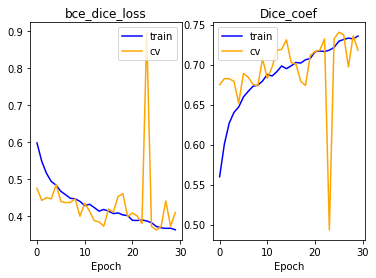

In [ ]:
plot_model_history(defect_3_history)

<br>

<br>

<br>

### Testting the segmentation model -3: (for defect-3)

In [ ]:
# To reload entire saved model (along with architecture,weights,object states)

import logging
logging.getLogger('tensorflow').disabled = True
tf.keras.backend.clear_session()


defect_3_model = tf.keras.models.load_model('/content/drive/My Drive/seg_models/defect_3/cp.ckpt/',
                                            custom_objects={'Bce_dice_loss':Bce_dice_loss,'Dicecoef':Dicecoef})


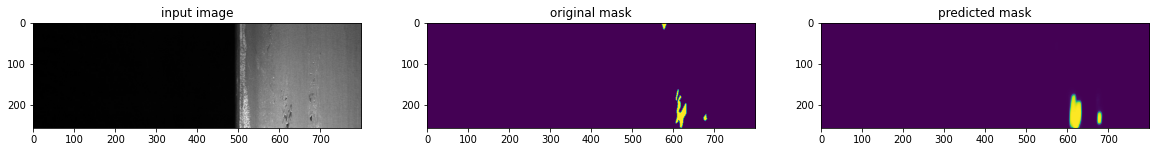

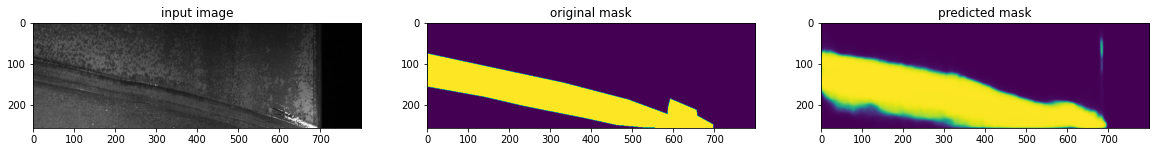

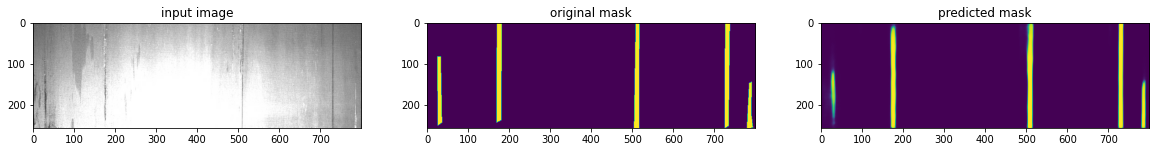

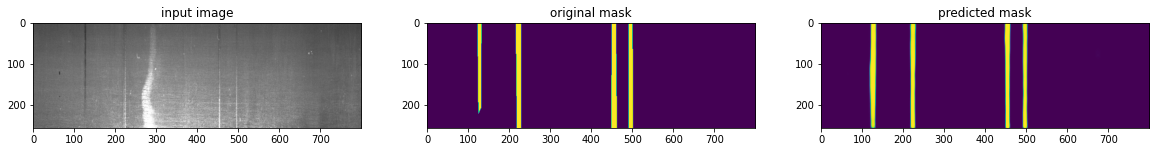

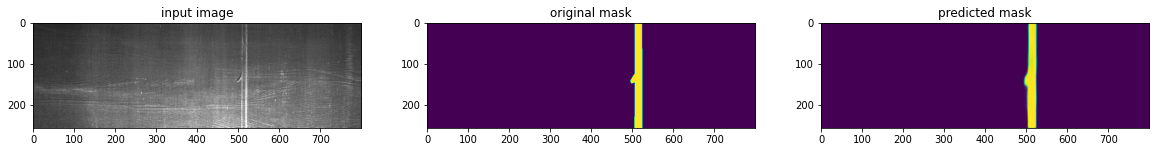

In [ ]:
for index,row in defect_3_val_data.loc[0:4].iterrows():
  image,mask = rle_decode_tf_test(row['image_id'],row['defect_3'])
  image_reshaped = np.expand_dims(image,axis=0)
  predicted_mask = defect_3_model.predict(image_reshaped)
  predicted_mask = np.squeeze(predicted_mask, axis=-1)
  predicted_mask = np.squeeze(predicted_mask, axis=0)

  fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20, 13))

  ax1.set_title('input image')
  ax1.imshow(image)

  ax2.set_title('original mask')
  ax2.imshow(mask)

  ax3.set_title('predicted mask')
  ax3.imshow(predicted_mask)
  

<br>

<br>

### 4.4 Building segmentation model for Defect-4:

### DataFrame Operations:

In [ ]:
# Filtering only Defect_1 ImageID's and Rle's:
#-----------------------------------------------

defect_4_train_data  = train_data[train_data['has_defect_4']==1][['image_id','defect_4']].reset_index(drop=True)
defect_4_val_data    = cv_data[cv_data['has_defect_4']==1][['image_id','defect_4']].reset_index(drop=True)


<br>

### Building pipelines:

In [ ]:
batch= 8
batch_val = 8
global iters_train

iters_train  =  defect_4_train_data.shape[0]//batch
iters_test   =  defect_4_val_data.shape[0]//batch

# creating the data pipeline
train_dataset   = tf.data.Dataset.from_tensor_slices((defect_4_train_data['image_id'], defect_4_train_data['defect_4']))
val_dataset     = tf.data.Dataset.from_tensor_slices((defect_4_val_data['image_id'] , defect_4_val_data['defect_4']))


train_dataset  = train_dataset.cache().shuffle(defect_4_train_data.shape[0],seed=batch,reshuffle_each_iteration=False)\
                .map(rle_decode_tf_train,num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(batch).prefetch(tf.data.experimental.AUTOTUNE)

# # We are creating 16 batch as we have 256,800 pixels i want to train which need more computation Power

val_dataset     = val_dataset.cache().map(rle_decode_tf_test,num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(batch_val).prefetch(tf.data.experimental.AUTOTUNE)


In [ ]:
seg_model.compile(optimizer=tf.keras.optimizers.Adam(),loss=Bce_dice_loss,metrics=[Dicecoef])

In [ ]:
# checkpoints for model saving:

checkpoint_path = "/content/drive/My Drive/seg_models/defect_4/cp.ckpt"
checkpoint_dir  = os.path.dirname(checkpoint_path)

cp_callback     = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                    save_weights_only=False,
                                                    save_best_only = False,
                                                    verbose=1)
#so that we can reload it whenever we want along with model architecture,weights and states
 


In [ ]:
defect_4_history = seg_model.fit(train_dataset, epochs=40, callbacks=[cp_callback], validation_data=val_dataset)

Epoch 1/40
86/86 [==============================] - ETA: 0s - loss: 0.9599 - Dicecoef: 0.3581
Epoch 00001: saving model to /content/drive/My Drive/seg_models/defect_4/cp.ckpt
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /content/drive/My Drive/seg_models/defect_4/cp.ckpt/assets
86/86 [==============================] - 198s 2s/step - loss: 0.9599 - Dicecoef: 0.3581 - val_loss: 14.3483 - val_Dicecoef: 0.1712
Epoch 2/40
86/86 [==============================] - ETA: 0s - loss: 0.7094 - Dicecoef: 0.4901
Epoch 00002: saving model to /content/drive/My Drive/seg_models/defect_4/cp.ckpt
INFO:tensorflow:Assets written to: /content/drive/My Drive/seg_models/defect_4/cp.ckpt/assets
86/86 [==============================] - 191s 2s/step - loss: 0.7094 - Dicecoef: 0.4901 - val_loss: 1.1974 - val_Dicecoef: 0.5655
Epoch 3/40
86/86 [==============================] - ETA: 0s - loss: 0.6357 - Dicecoef: 0.5438
Epoch 00003: saving model 

In [ ]:
# dump history in file (for future reference):

with open('/content/drive/My Drive/seg_models/defect_4/history', 'wb') as file_pi:
        pickle.dump(defect_4_history.history, file_pi)

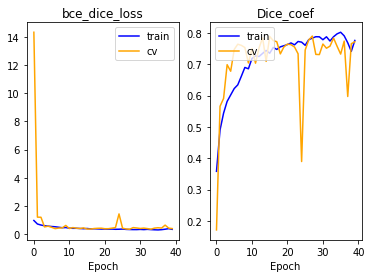

In [ ]:
plot_model_history(defect_4_history)

### Testting the segmentation model -3: (for defect-3)

In [ ]:
# To reload entire saved model (along with architecture,weights,object states)

import logging
logging.getLogger('tensorflow').disabled = True
tf.keras.backend.clear_session()


defect_4_model = tf.keras.models.load_model('/content/drive/My Drive/seg_models/defect_4/cp.ckpt/',
                                            custom_objects={'Bce_dice_loss':Bce_dice_loss,'Dicecoef':Dicecoef})


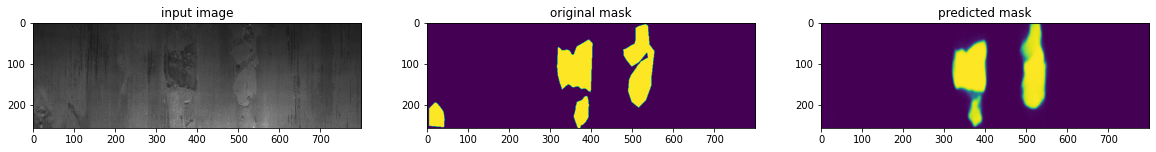

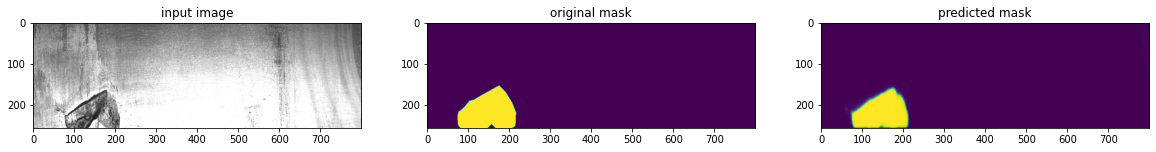

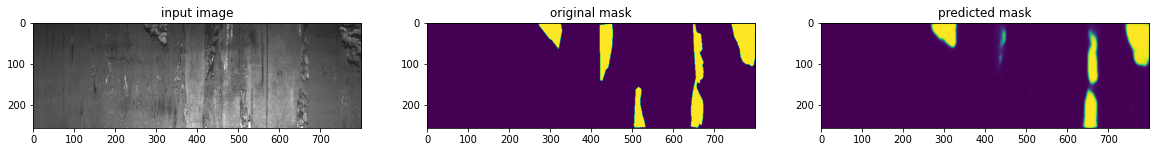

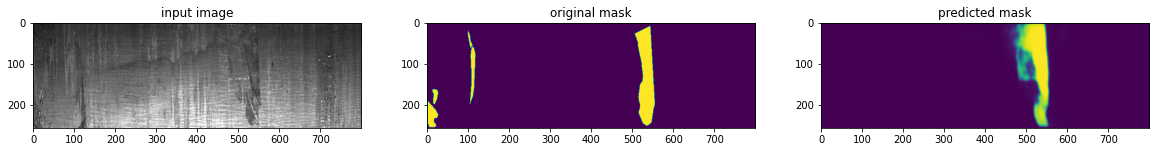

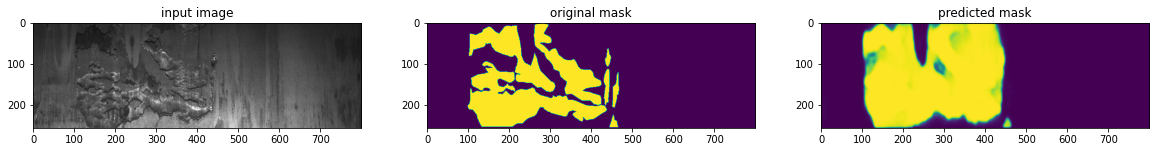

In [ ]:
for index,row in defect_4_val_data.loc[0:4].iterrows():
  image,mask = rle_decode_tf_test(row['image_id'],row['defect_4'])
  image_reshaped = np.expand_dims(image,axis=0)
  predicted_mask = defect_4_model.predict(image_reshaped)
  predicted_mask = np.squeeze(predicted_mask, axis=-1)
  predicted_mask = np.squeeze(predicted_mask, axis=0)

  fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20, 13))

  ax1.set_title('input image')
  ax1.imshow(image)

  ax2.set_title('original mask')
  ax2.imshow(mask)

  ax3.set_title('predicted mask')
  ax3.imshow(predicted_mask)
  